# Estimating GGM using Score Matching

In [1]:
import HD, NPGM
# reload("HD")
# reload("NPGM")

Generate Gaussian data from which we will be learning the structure. The covariance is a Toeplitz matrix, that is, $\Sigma = (\sigma_{ab})$ with $\sigma_{ab} = \rho^{|a-b|}$.

In [2]:
function gen_data_chain(n::Int64, p::Int64, rho::Float64; zero_thr=1e-4)

    Sigma = zeros(Float64, p, p)
    for a=1:p
        for b=1:p
            Sigma[a,b] = rho^abs(a-b)
        end
    end
    Theta = inv(Sigma)
    Theta[find(abs(Theta) .< zero_thr)] = 0.
    
    X = randn(n, p) * sqrtm(Sigma), Sigma, Theta
end

gen_data_chain (generic function with 1 method)

Run Group Lasso

In [20]:
K = 1
L = 1
n = 500
p = 30
rho = 0.8
numColumns = int(p*K+p*(p-1)/2*L)
groups = Array(Array{Int64, 1}, numColumns)
for i=1:numColumns
    groups[i] = [i]
end
mask = ones(Float64, numColumns)
mask[1:p*K] = 0.;

In [40]:
numRep = 10
lambdaArr = logspace(log10(3), log10(0.3), 30)
numLambda = length(lambdaArr)
pathSol = cell(numRep, numLambda)

@time for rep = 1:numRep
    X, _, _ = gen_data_chain(n,p,rho)
    
    DD = NPGM.getDD(X, K, L, NPGM.gm_node_der_f, NPGM.gm_edge_der_f)
    E = NPGM.getE(X, K, L, NPGM.gm_node_der_2_f, NPGM.gm_edge_der_2_f)
    
    scale!(E, -1./n)   # note -1 because of group lasso interface
    scale!(DD, 1./n)    
    
    solution = zeros(Float64, numColumns)
    for indLambda=1:numLambda
        HD.group_lasso!(solution, DD, E, groups, lambdaArr[indLambda]*mask)
        
        solution[find(abs(solution) .< 1e-4)] = 0.
        eThetaSp = zeros(Float64, p, p)
        NPGM.getPrecision(eThetaSp, p, solution)
        pathSol[rep, indLambda] = eThetaSp        
    end
end

elapsed time: 17.838836137 seconds (5078616208 bytes allocated, 20.84% gc time)


In [41]:
Sigma = zeros(Float64, p, p)
for a=1:p
    for b=1:p
        Sigma[a,b] = rho^abs(a-b)
    end
end
Theta = inv(Sigma)
Theta[find(abs(Theta) .< 1e-4)] = 0.

trueSparsity = spones(sparse(Theta))

hammingDistance = zeros(numRep, numLambda)
for rep=1:numRep
    for indLambda=1:numLambda    
        estimSparsity = spones(sparse(pathSol[rep, indLambda]))    
        hammingDistance[rep, indLambda] = nnz(trueSparsity - estimSparsity) / 2.
    end
end

In [10]:
using PyPlot

INFO: Loading help data...


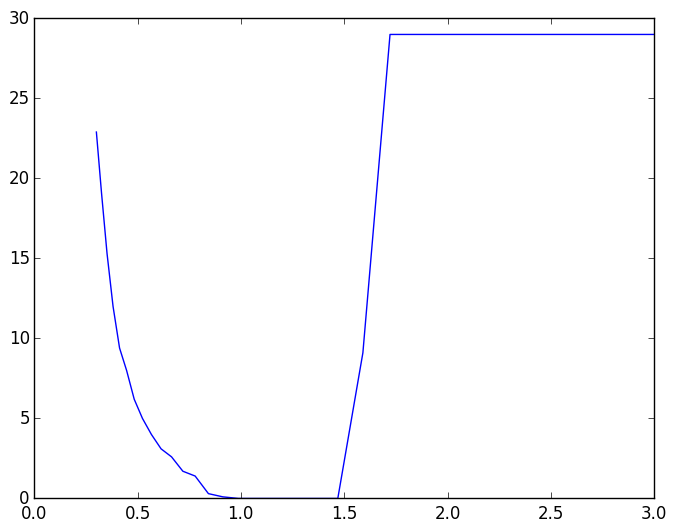

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1bd021a410>

In [42]:
plot(lambdaArr, vec(mean(hammingDistance, 1)))

### Slow ways to compute DD

In [9]:
# # This should not be run -- slower
# D = getD(X, 1, K, L, phi_node_der, phi_edge_der)
# DD1 = D'D
# @time for i=2:n
#     D = getD(X, i, K, L, phi_node_der, phi_edge_der)    
#     tnz = (D'D).nzval
#     DDnz = DD1.nzval    
#     for j=1:length(DDnz)
#         @inbounds DDnz[j] = DDnz[j] + tnz[j]
#     end
# end
# @time E = getE(X, K, L, phi_node_der_2, phi_edge_der_2);

In [10]:
# # This should not be run -- shows how slow the other approach is
# DD1 = zeros(Float64, numFeatures, numFeatures)
# @time for i=1:n
#     D = getD(X, i, K, L, phi_node_der, phi_edge_der)
#     broadcast!(+, DD1, DD1, D'D)
# end
# # DD = sparse(DD);
# @time E = getE(X, K, L, phi_node_der_2, phi_edge_der_2);
# maximum(abs(DD1-DD))

###Test case 

Without penalty, we should get back the inverse of the covariance matrix.

In [59]:
eTmp = -DD \ E
eTheta = zeros(Float64, p, p)
getPrecision(eTheta, p, eTmp)
maximum(abs(eTheta - inv(X'X/n)))

CHOLMOD warning: matrix not positive definite


13.164281562842719

### Speed comparison

In [115]:
D = getD(X, 1, K, L, phi_node_der, phi_edge_der)
DD = D'D
@time for i=2:n
    D = getD(X, i, K, L, phi_node_der, phi_edge_der)
    broadcast!(+, DD.nzval, DD.nzval, (D'D).nzval)
end
@time E = getE(X, K, L, phi_node_der_2, phi_edge_der_2);
@time DD1 = getDD(X, K, L, phi_node_der, phi_edge_der);

elapsed time: 17.278545179 seconds (29300553480 bytes allocated, 5.42% gc time)
elapsed time: 0.325628994 seconds (237552528 bytes allocated)
elapsed time: 2.501415187 seconds (367830448 bytes allocated, 3.58% gc time)
